In [17]:
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [2]:
# Load data
OE_detailed = pd.read_parquet(Path("../data/processed/oe_detailed.parquet"))
OE_Activity_prepped = pd.read_parquet(Path("../data/processed/oe_activity_prepped.parquet"))
OE_joined = pd.read_parquet(Path("../data/processed/oe_joined.parquet"))    

In [3]:
display(OE_detailed.head(3))

,ActivityCode,UserID,WorkCode,AssignmentID,ProductID,Quantity,Timestamp,LocationID,Prev_Timestamp,Prev_LocationID,...,Prev_Bay,Prev_Level,Prev_Slot,Aisle2,Bay2,Prev_Aisle2,Prev_Bay2,LocKey,PrevLocKey,Distance
0,PickPut,64,20,7955278,3250,1,2025-11-10 12:23:59.540,34343,NaT,<NA>,...,<NA>,<NA>,<NA>,42,12,<NA>,<NA>,42|12|||,<NA>|<NA>|||,NaN
1,PickPut,64,20,7955281,43178,1,2025-11-10 12:26:23.993,14453,2025-11-10 12:23:59.540,34343,...,12,6,7,34,26,42,12,34|26|||,42|12|||,220.0
2,PickPut,64,20,7955279,5842,1,2025-11-10 12:28:31.110,23294,2025-11-10 12:26:23.993,14453,...,26,6,1,42,05,34,26,42|05|||,34|26|||,514.0


In [4]:
df = OE_Activity_prepped.copy()
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df = df.dropna(subset=["Timestamp"]).copy()

# ShiftDay is the calendar date of the 5am-based day
df["ShiftDay"] = (df["Timestamp"] - pd.Timedelta(hours=5)).dt.date

# Keep only events inside the shift window: [05:00, next day 02:00)
t = df["Timestamp"].dt.time
in_window = (t >= pd.to_datetime("05:00").time()) | (t < pd.to_datetime("02:00").time())
df = df[in_window].copy()

# Sort within user + ShiftDay
df = df.sort_values(["UserID", "ShiftDay", "Timestamp"]).reset_index(drop=True)

# Recompute within-shift deltas (don’t use global Time_Delta_sec here)
g = df.groupby(["UserID", "ShiftDay"], sort=False)
df["Prev_Timestamp_shift"] = g["Timestamp"].shift(1)
df["Time_Delta_shift_sec"] = (df["Timestamp"] - df["Prev_Timestamp_shift"]).dt.total_seconds()

# Break time: deltas >= 20 minutes
df["Break_sec"] = np.where(df["Time_Delta_shift_sec"] >= 20 * 60, df["Time_Delta_shift_sec"], 0.0)

# Start time must be after 5am: take first timestamp (already filtered in-window)
# End time can go to 2am next day: last timestamp in the group (still in-window)
shift_table = (
    df.groupby(["UserID", "ShiftDay"], dropna=False)
      .agg(
          start_time=("Timestamp", "min"),
          end_time=("Timestamp", "max"),
          break_time_sec=("Break_sec", "sum"),
          n_events=("Timestamp", "size"),
      )
      .reset_index()
)

# Shift length
shift_table["shift_length_sec"] = (shift_table["end_time"] - shift_table["start_time"]).dt.total_seconds()

# Convert to hours/min for presentation
shift_table["shift_length_hr"] = shift_table["shift_length_sec"] / 3600
shift_table["break_time_min"] = shift_table["break_time_sec"] / 60

shift_table.head()

,UserID,ShiftDay,start_time,end_time,break_time_sec,n_events,shift_length_sec,shift_length_hr,break_time_min
0,64,2025-11-10,2025-11-10 12:23:59.540,2025-11-10 22:53:47.447,17247.363,147,37787.907,10.496641,287.456050
1,64,2025-11-11,2025-11-11 12:25:13.927,2025-11-11 19:27:17.540,6843.642,145,25323.613,7.034337,114.060700
2,64,2025-11-12,2025-11-12 12:31:32.900,2025-11-12 21:39:04.530,9855.044,159,32851.630,9.125453,164.250733
3,64,2025-11-13,2025-11-13 13:00:06.033,2025-11-13 21:56:29.163,14965.110,157,32183.130,8.939758,249.418500
4,64,2025-12-01,2025-12-01 11:40:34.920,2025-12-02 01:17:23.597,25711.489,206,49008.677,13.613521,428.524817


In [5]:
# Display rows with very long break lengths > 5 h
long_breaks = shift_table[shift_table["break_time_min"] > 5 * 60]
display(long_breaks[["UserID", "ShiftDay", "start_time", "end_time", "shift_length_hr", "break_time_min", "n_events"]])

,UserID,ShiftDay,start_time,end_time,shift_length_hr,break_time_min,n_events
4,64,2025-12-01,2025-12-01 11:40:34.920,2025-12-02 01:17:23.597,13.613521,428.524817,206
17,90,2025-11-12,2025-11-12 13:47:59.213,2025-11-12 22:11:33.793,8.392939,452.199333,26
18,90,2025-12-01,2025-12-01 12:26:42.000,2025-12-02 01:34:01.790,13.122164,511.869617,106
29,217,2025-11-10,2025-11-10 12:06:59.997,2025-11-10 22:36:09.347,10.485931,377.379383,229
31,217,2025-11-12,2025-11-12 11:57:59.697,2025-11-12 22:15:29.630,10.291648,413.630050,254
32,217,2025-11-13,2025-11-13 12:01:15.127,2025-11-13 21:45:04.653,9.730424,457.670733,146
33,217,2025-12-01,2025-12-01 12:45:55.733,2025-12-02 01:12:34.613,12.444133,475.067200,382
34,217,2025-12-02,2025-12-02 12:32:39.737,2025-12-02 22:48:40.553,10.266893,397.168000,167


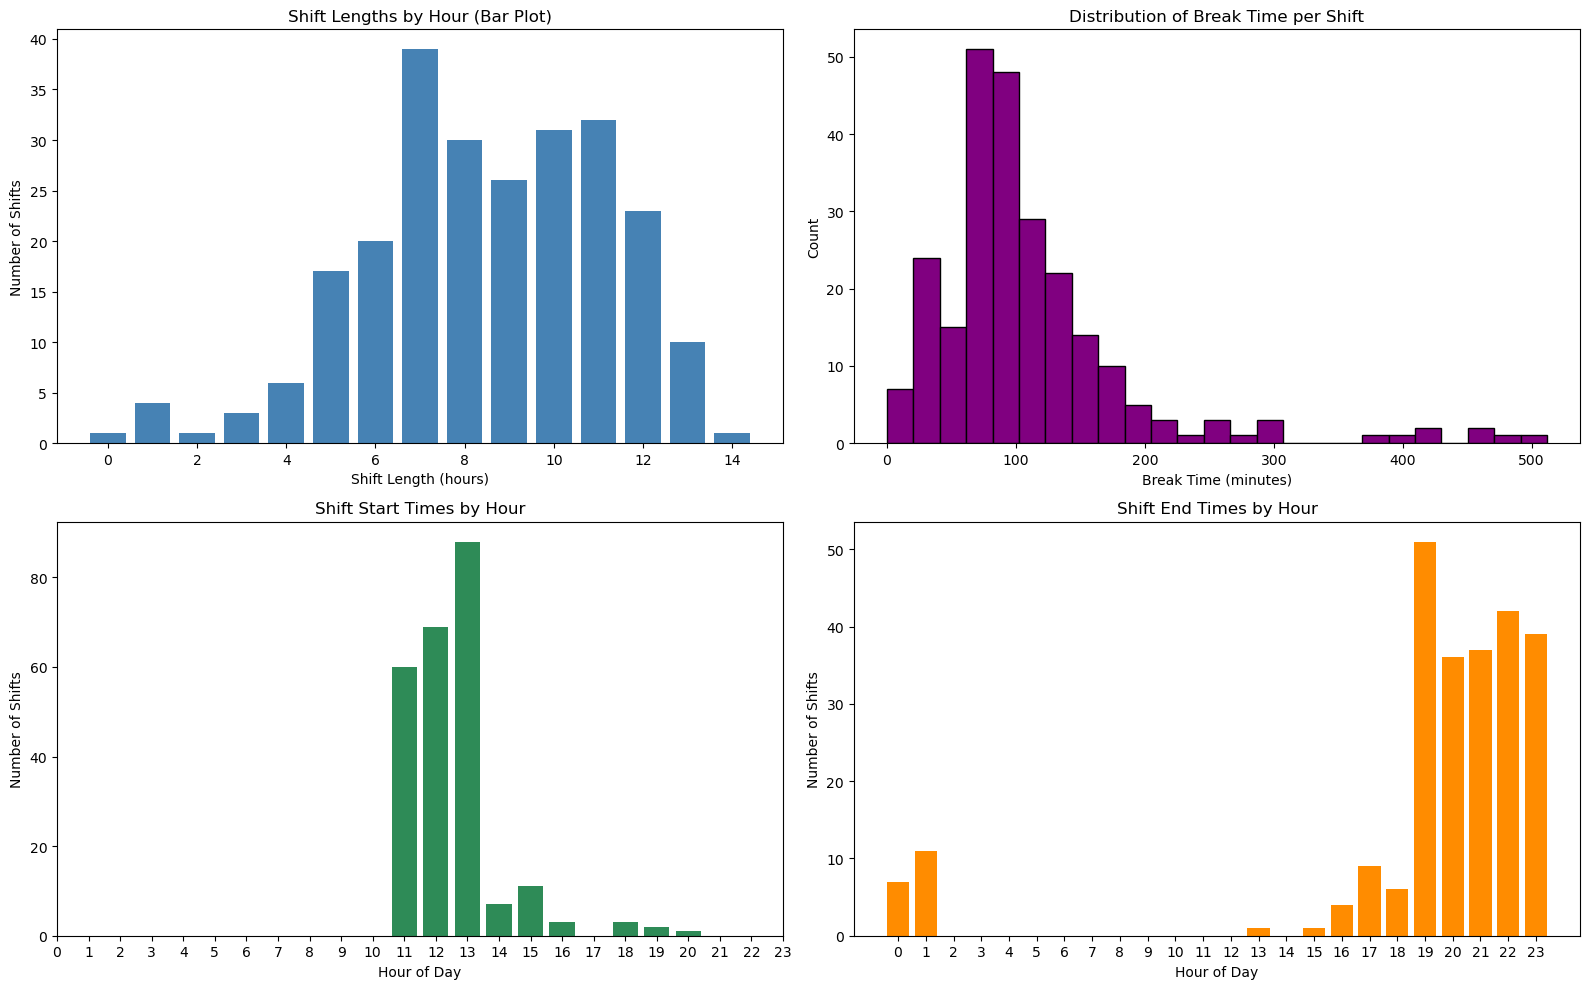

In [8]:
st = shift_table.copy()

st["start_hour"] = st["start_time"].dt.hour
st["end_hour"] = st["end_time"].dt.hour

# Bin shift lengths into whole hours for bar plot
st["shift_length_hour_bin"] = st["shift_length_hr"].round().astype(int)

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ---- 1) Shift length bar plot by hour ----
length_counts = st["shift_length_hour_bin"].value_counts().sort_index()

axes[0, 0].bar(length_counts.index, length_counts.values, color="steelblue")
axes[0, 0].set_title("Shift Lengths by Hour (Bar Plot)")
axes[0, 0].set_xlabel("Shift Length (hours)")
axes[0, 0].set_ylabel("Number of Shifts")

# ---- 2) Break time distribution histogram ----
axes[0, 1].hist(st["break_time_min"], bins=25, color="purple", edgecolor="black")
axes[0, 1].set_title("Distribution of Break Time per Shift")
axes[0, 1].set_xlabel("Break Time (minutes)")
axes[0, 1].set_ylabel("Count")

# ---- 3) Shift start times bar plot ----
start_counts = st["start_hour"].value_counts().sort_index()

axes[1, 0].bar(start_counts.index, start_counts.values, color="seagreen")
axes[1, 0].set_title("Shift Start Times by Hour")
axes[1, 0].set_xlabel("Hour of Day")
axes[1, 0].set_ylabel("Number of Shifts")
axes[1, 0].set_xticks(range(24))

# ---- 4) Shift end times bar plot ----
end_counts = st["end_hour"].value_counts().sort_index()

axes[1, 1].bar(end_counts.index, end_counts.values, color="darkorange")
axes[1, 1].set_title("Shift End Times by Hour")
axes[1, 1].set_xlabel("Hour of Day")
axes[1, 1].set_ylabel("Number of Shifts")
axes[1, 1].set_xticks(range(24))

plt.tight_layout()
plt.show()

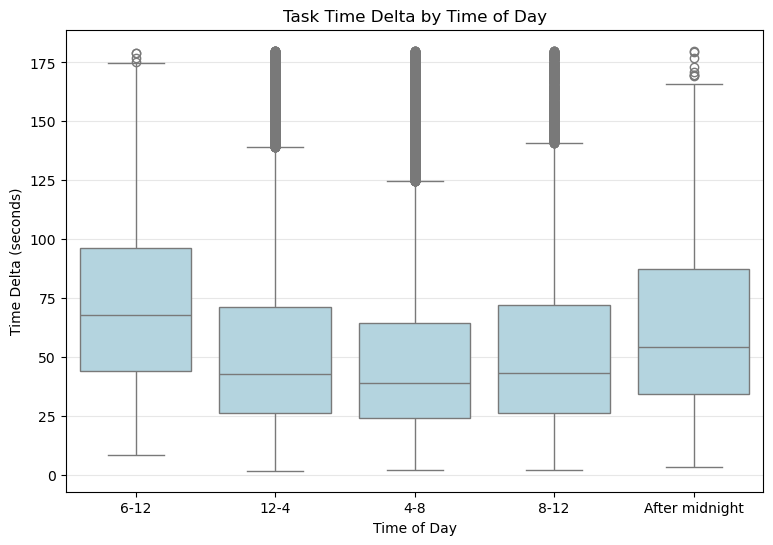

In [19]:
df = OE_joined.copy()
df = df.dropna(subset=["Timestamp"]).copy()
df = df[df["LocationID"] != df["Prev_LocationID"]].copy()
df = df[df["Time_Delta_sec"] > 0].copy()
df = df[df["Time_Delta_sec"] < 180].copy()
df["Hour"] = df["Timestamp"].dt.hour

# Define time-of-day buckets
def time_bucket(h):
    if 6 <= h < 12:
        return "6-12"
    elif 12 <= h < 16:
        return "12-4"
    elif 16 <= h < 20:
        return "4-8"
    elif 20 <= h < 24:
        return "8-12"
    else:
        return "After midnight"

df["DayPart"] = df["Hour"].apply(time_bucket)

order = ["6-12", "12-4", "4-8", "8-12", "After midnight"]

plt.figure(figsize=(9, 6))

sns.boxplot(
    data=df,
    x="DayPart",
    y="Time_Delta_sec",
    order=order,
    color="lightblue"
)

plt.title("Task Time Delta by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Time Delta (seconds)")
plt.grid(axis="y", alpha=0.3)

plt.show()

In [13]:
df = OE_Activity_prepped.copy()

df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")
df = df.dropna(subset=["Timestamp"]).copy()

df["Date"] = df["Timestamp"].dt.date
df["Hour"] = df["Timestamp"].dt.hour

workers_per_hour = (
    df.groupby(["Date", "Hour"])["UserID"]
      .nunique()
      .reset_index(name="ActiveWorkers")
)

avg_workers_by_hour = (
    workers_per_hour
    .groupby("Hour")["ActiveWorkers"]
    .mean()
    .reset_index()
)

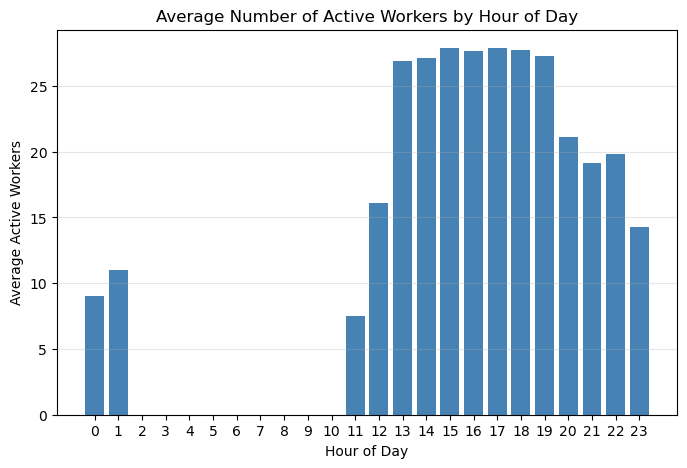

In [12]:
plt.figure(figsize=(8, 5))

plt.bar(avg_workers_by_hour["Hour"],
        avg_workers_by_hour["ActiveWorkers"],
        color="steelblue")

plt.title("Average Number of Active Workers by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Active Workers")
plt.xticks(range(24))
plt.grid(axis="y", alpha=0.3)

plt.show()